In [1]:
from nes_py.wrappers import JoypadSpace
import retro
import gym

from matplotlib import pyplot as plt
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import VecFrameStack
import os
from stable_baselines3 import PPO

from stable_baselines3.common.results_plotter import load_results, ts2xy
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback

import cv2
import pandas as pd

CHECK_FREQ_NUMB = 10000
TOTAL_TIMESTEP_NUMB = 2000000
# LEARNING_RATE = 0.00005
LEARNING_RATE = 0.00005
N_STEPS = 1024
GAMMA = 0.99
BATCH_SIZE = 64
N_EPOCHS = 10
DOWN_SAMPLE_RATE = 3
SKIP_NUMB = 4
EPISODE_NUMBERS = 20

CHECKPOINT_DIR = './training/'
LOG_DIR = './logs/'
REWARD_LOG_FILENAME = 'reward_log.csv'

# with open(REWARD_LOG_FILENAME, 'a') as f:
#     print('timesteps,reward', file=f)


# 计算奖励函数
class DeadlockEnv(gym.Wrapper):
    def __init__(self, env, threshold=10):
        super().__init__(env)
        self.last_lives = 2
        self.count = 0
        self.threshold = threshold
        self.last_xscroll = 0
        self.score=0

        
    def reset(self, **kwargs):
        self.score=0
        self.last_lives = 2
        self.count = 0
        self.last_xscroll = 0
        return self.env.reset(**kwargs)

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        self.env.render()
        ifdie=info['die']
        lives = info['lives']
        score =  info['score']
        xscroll=info['xscroll']
        boss_defeated=info['beat_boss']
        if score>self.score:
            reward+=(score-self.score)/100
        # 失去生命减分
        # if lives <self.last_lives:
        #     reward-=3000
        #     self.last_lives=lives
        # 防止卡死
        if xscroll <= self.last_xscroll and xscroll <3072:
            self.count += 1
        else:
            self.count = 0
        if self.count >= 400:
            reward -= 100
            done = True
        
        if ifdie != 1:
            reward-=1
        if xscroll > self.last_xscroll:
            reward+=0.1
            self.last_xscroll=xscroll            
        # if lives ==1:
        #     done=True
        # 通关得分
        if boss_defeated==8:
            reward += 5000
        return state, reward, done, info

# 跳过画面每2真保留一个画面，节省计算时间
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if done:
                break
        return obs, reward, done, info

class Downsample(gym.ObservationWrapper):
    def __init__(self, env, ratio):
        """
        Downsample images by a factor of ratio
        """
        gym.ObservationWrapper.__init__(self, env)
        (oldh, oldw, oldc) = env.observation_space.shape
        newshape = (oldh//ratio, oldw//ratio, oldc)
        self.observation_space = gym.spaces.Box(low=0, high=255,
            shape=newshape, dtype=np.uint8)

    def observation(self, frame):
        height, width, _ = self.observation_space.shape
        frame = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
        if frame.ndim == 2:
            frame = frame[:,:,None]
        return frame

class Discretizer(gym.ActionWrapper):
    """
    Wrap a gym environment and make it use discrete actions.
    Args:
        combos: ordered list of lists of valid button combinations
    """

    def __init__(self, env, combos):
        super().__init__(env)
        assert isinstance(env.action_space, gym.spaces.MultiBinary)
        buttons = env.unwrapped.buttons
        self._decode_discrete_action = []
        for combo in combos:
            arr = np.array([False] * env.action_space.n)
            for button in combo:
                arr[buttons.index(button)] = True
            self._decode_discrete_action.append(arr)

        self.action_space = gym.spaces.Discrete(
            len(self._decode_discrete_action))

    def action(self, act):
        return self._decode_discrete_action[act].copy()


class SonicDiscretizer(Discretizer):
    """
    Use Sonic-specific discrete actions
    based on https://github.com/openai/retro-baselines/blob/master/agents/sonic_util.py
    """
    # B是子弹

    def __init__(self, env):
        super().__init__(env=env, combos=[['RIGHT', 'B'],['RIGHT'],['RIGHT', 'A', 'B'], ['B'],['LEFT', 'A', 'B'],['RIGHT', 'UP', 'B']])


# env = retro.make(game='Contra-Nes' ,state="Level1",record="./record/.")
env = retro.make(game='Contra-Nes' ,state="Level1-99")
# 限制按键
env = SonicDiscretizer(env)
# 计算奖励函数
env = DeadlockEnv(env)
# 跳过一阵的画面
env = SkipFrame(env, skip=SKIP_NUMB)
monitor_dir = r'./monitor_log/'
os.makedirs(monitor_dir,exist_ok=True)
env = Monitor(env,monitor_dir)

env = GrayScaleObservation(env,keep_dim=True)
# 把画面的画质除以3
# (224, 240, 1)
# 变成
# (74, 80, 1)
env = Downsample(env, DOWN_SAMPLE_RATE)

env = DummyVecEnv([lambda: env])
env = VecFrameStack(env,4,channels_order='last')

class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

            total_reward = [0] * EPISODE_NUMBERS
            total_time = [0] * EPISODE_NUMBERS
            best_reward = 0

            for i in range(EPISODE_NUMBERS):
                state = env.reset()  # reset for each new trial
                done = False
                total_reward[i] = 0
                total_time[i] = 0
                while not done and total_time[i] < 10000:
                    action, _ = model.predict(state)
                    state, reward, done, info = env.step(action)
                    total_reward[i] += reward[0]
                    total_time[i] += 1

                if total_reward[i] > best_reward:
                    best_reward = total_reward[i]
                    best_epoch = self.n_calls

                state = env.reset()  # reset for each new trial

            print('time steps:', self.n_calls, '/', TOTAL_TIMESTEP_NUMB)
            print('average reward:', (sum(total_reward) / EPISODE_NUMBERS),
                  'average time:', (sum(total_time) / EPISODE_NUMBERS),
                  'best_reward:', best_reward,
                  )

            with open(REWARD_LOG_FILENAME, 'a') as f:
                print(self.n_calls, ',', sum(total_reward) / EPISODE_NUMBERS, file=f)

        return True

class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq, save_model_dir, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = os.path.join(save_model_dir, 'best_model/')
        self.best_mean_reward = -np.inf

    # def _init_callback(self) -> None:
    def _init_callback(self):
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    # def _on_step(self) -> bool:
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            print('self.n_calls: ',self.n_calls)
            model_path1 = os.path.join(self.save_path, 'model_{}'.format(self.n_calls))
            self.model.save(model_path1)
        return True

# ! 设置你要保存模型的位置

# save_model_dir = r'./training/'
# model = PPO("CnnPolicy", env, verbose=1,
#             # tensorboard_log = tensorboard_log,
#             learning_rate = LEARNING_RATE,
#             # device="cuda:0",
#             )
# load model 读取之前训练好的模型
# model.set_parameters("best_model")
# callback1 = SaveOnBestTrainingRewardCallback(10000, save_model_dir)
# model.learn(total_timesteps=1200000,callback=callback1)
# model.save("mario_model")

# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=CHECK_FREQ_NUMB, save_path=CHECKPOINT_DIR)
# This is the AI model started
model = PPO('CnnPolicy', env, verbose=0, tensorboard_log=LOG_DIR, learning_rate=LEARNING_RATE, n_steps=N_STEPS,
            batch_size=BATCH_SIZE, n_epochs=N_EPOCHS, gamma=GAMMA)
model.set_parameters("best_model")



<AxesSubplot:xlabel='timesteps'>

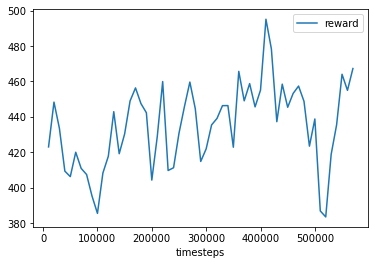

In [2]:
reward_log = pd.read_csv(REWARD_LOG_FILENAME, index_col='timesteps')
reward_log.plot()


In [3]:
best_epoch = reward_log['reward'].idxmax()
print('best epoch:', best_epoch)

best epoch: 410000


In [4]:
import copy

model.set_parameters("best_model")
total_reward = [0] * EPISODE_NUMBERS
total_time = [0] * EPISODE_NUMBERS
best_reward = 0
frames_best = []

for i in range(EPISODE_NUMBERS):
    state = env.reset()  # reset for each new trial
    done = False
    total_reward[i] = 0
    total_time[i] = 0
    frames = []
    fps=0
    while not done and total_time[i] < 10000:
        action, _ = model.predict(state)
        state, reward, done, info = env.step(action)
        total_reward[i] += reward[0]
        total_time[i] += 1
        env.render()
        fps+=1
        frames.append(copy.deepcopy(env.render(mode='rgb_array')))

    if total_reward[i] > best_reward:
        best_reward = total_reward[i]
        frames_best = copy.deepcopy(frames)

    print('test episode:', i, 'reward:', total_reward[i], 'time:', total_time[i],'fps:', fps)

print('average reward:', (sum(total_reward) / EPISODE_NUMBERS),
      'average time:', (sum(total_time) / EPISODE_NUMBERS),
      'best_reward:', best_reward)

c:\ProgramData\Anaconda3\lib\site-packages\pyglet\image\codecs\wic.py:292: UserWarning: [WinError -2147417850] 无法在设置线程模式后对其加以更改。
  warnings.warn(str(err))


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import display, HTML


In [ ]:
frames_new = np.array(frames_best)
matplotlib.rcParams['animation.embed_limit'] = 2**128
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames_new[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames_new[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames_new), interval = 50)
display(HTML(ani.to_jshtml()))
plt.close()

: 

: 

In [ ]:
env.close()

: 